# <font color='red'>Clustering Assignment</font>

In [ ]:
!pip install networkx==2.3

In [ ]:
!pip install stellargraph

In [47]:
import networkx as nx
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [54]:
# Data loading
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [55]:
edges = [tuple(x) for x in data.values.tolist()]

In [56]:
# Creating a bipartite graph out of the data
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [57]:
A = list(nx.connected_component_subgraphs(B))[0]

In [58]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


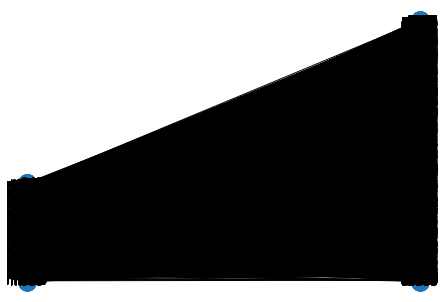

In [59]:
# ploting of the nodes and the edges for the data
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [60]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [61]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [62]:
# converting the random walks to the w2v dimensions
model = Word2Vec(walks, size=128, window=5)

In [63]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [64]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [65]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]

    for i in range(len(node_ids)):
      if 'm' in node_ids[i] and node_targets[i]=='movie':
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
      if 'a' in node_ids[i] and node_targets[i]=='actor':
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings= data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [66]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [67]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [68]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    ''' refer: https://stackoverflow.com/questions/61279372/connected-components-of-bipartite-graphs '''
    conected_graph = graph.subgraph(next(nx.connected_components(graph)))
    cost1= (len(conected_graph.nodes)/graph.number_of_nodes())/number_of_clusters
    
    return cost1

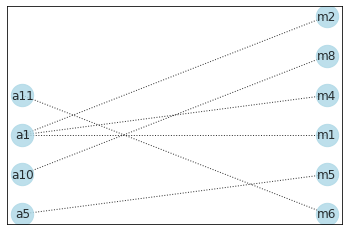

In [69]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [70]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [80]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost2 for actor'''
    # node_map=graph.degree()
    # sum_degree=sum(list(dict(node_map).values()))
    edges=graph.number_of_edges()
    nodes=0
    for i in graph.nodes():
      if 'm' in i:
        nodes=nodes+1

    cost2= (edges/nodes)/number_of_clusters
    
    return cost2

In [82]:
def cost2movie(graph,number_of_clusters):
    '''In this function, we will calculate cost2 for movies'''
    # node_map=graph.degree()
    # sum_degree=sum(list(dict(node_map).values()))
    edges=graph.number_of_edges()
    nodes=0
    for i in graph.nodes():
      if 'a' in i:
        nodes=nodes+1

    cost2= (edges/nodes)/number_of_clusters
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [81]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

## Getting the best k value for applying kmeans

In [78]:
def getnodecluster(lables, nodes):
  ''' getnodecluster is teh function for geting the node clusters list based on the k value'''
  node_dict={}
  node_cluster_list=[]
  for i in range(len(nodes)):
    node_dict[nodes[i]]=lables[i]

  ''' Creating the clusters list of nodes '''
  for number in np.unique(lables):
    cluster=[]
    for node,cluster_num in node_dict.items():
      if number == cluster_num:
        cluster.append(node)
    node_cluster_list.append(cluster)

    return node_cluster_list


In [86]:
# Hyperparameter tuning of the k value for best k value
cost_list=[]
k_list=[3, 5, 10, 30, 50, 100, 200, 500]
for number_of_clusters in k_list:
  kmeans_algo=KMeans(n_clusters=number_of_clusters)
  kmeans_algo.fit(actor_embeddings)
  lables=kmeans_algo.labels_
  
  actor_cluster_list=getnodecluster(lables,actor_nodes)
  ''' creating the subgraphs based on the k value '''
  cost_1,cost_2=0,0
  for cluster in actor_cluster_list:
    G = nx.Graph()
    for node in cluster:
      node_ego=nx.ego_graph(B,node)
      G.add_nodes_from(node_ego.nodes())
      G.add_edges_from(node_ego.edges())
    cost_1=+cost1(G,number_of_clusters)
    cost_2=+cost2(G,number_of_clusters)

  cost_list.append(cost_1*cost_2)


max_index=cost_list.index(max(cost_list))
print("Best k value for kmeans is : ",k_list[max_index])
  



Best k value for kmeans is :  3


<font color='blue'>Displaying similar actor clusters</font>

In [87]:
''' Training kmeans with best k value for actor embedings '''
kmeans_algo=KMeans(n_clusters=k_list[max_index])
kmeans_algo.fit(actor_embeddings)  
lables=kmeans_algo.labels_

''' transform the actor_embeding into 2 d form from 128 dimensions '''
transform = TSNE
trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

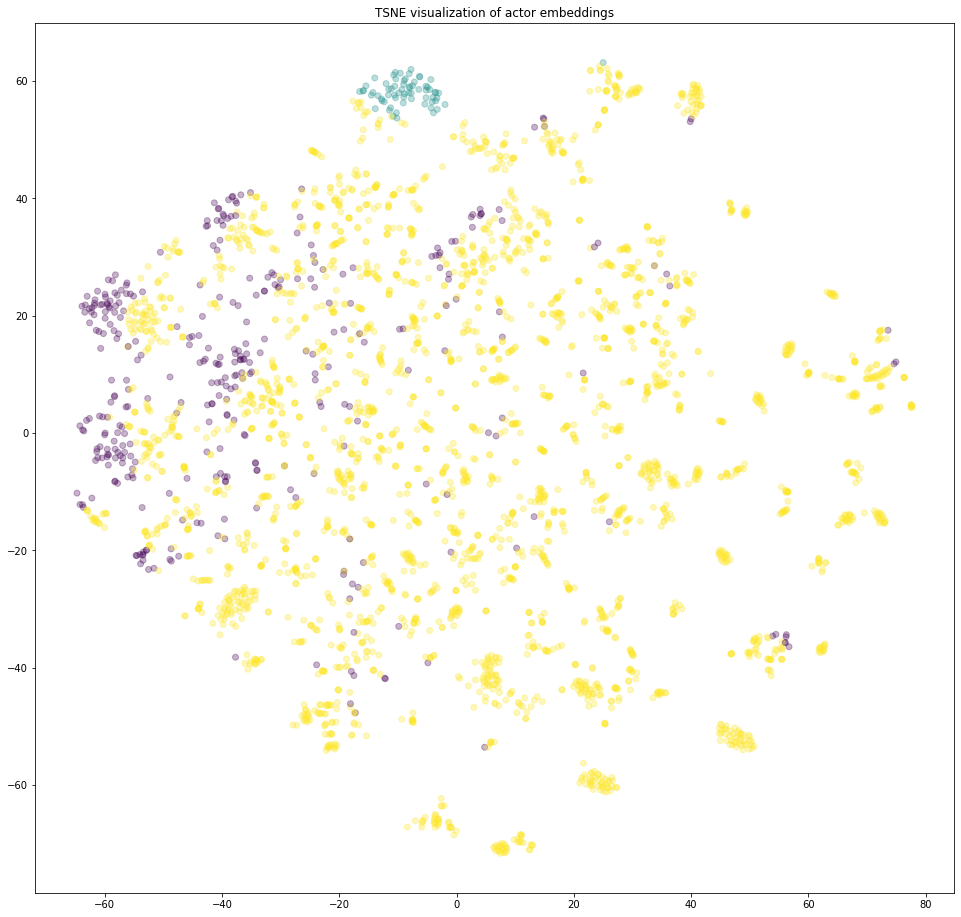

In [88]:
''' ploting of the actor clusters '''
label_map = { l: i for i, l in enumerate(np.unique(lables))}
node_colours = [label_map[target] for target in lables]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

<font color='blue'>Grouping similar movies</font>

In [89]:
# Hyperparameter tuning of the k value for best k value
cost_list=[]
k_list=[3, 5, 10, 30, 50, 100, 200, 500]
for number_of_clusters in k_list:
  kmeans_algo=KMeans(n_clusters=number_of_clusters)
  kmeans_algo.fit(movie_embeddings)
  lables=kmeans_algo.labels_
  
  movie_cluster_list=getnodecluster(lables,movie_nodes)
  ''' creating the subgraphs based on the k value '''
  cost_1,cost_2=0,0
  for cluster in movie_cluster_list:
    G = nx.Graph()
    for node in cluster:
      node_ego=nx.ego_graph(B,node)
      G.add_nodes_from(node_ego.nodes())
      G.add_edges_from(node_ego.edges())
    cost_1=+cost1(G,number_of_clusters)
    cost_2=+cost2movie(G,number_of_clusters)
  cost_list.append(cost_1*cost_2)


max_index=cost_list.index(max(cost_list))
print("Best k value for kmeans is : ",k_list[max_index])

Best k value for kmeans is :  3


<font color='blue'>Displaying similar movie clusters</font>

In [90]:
''' Training kmeans with best k value for movie embedings '''
kmeans_algo=KMeans(n_clusters=k_list[max_index])
kmeans_algo.fit(movie_embeddings)  
lables=kmeans_algo.labels_

''' transform the movie_embeding into 2 d form from 128 dimensions '''
transform = TSNE
trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

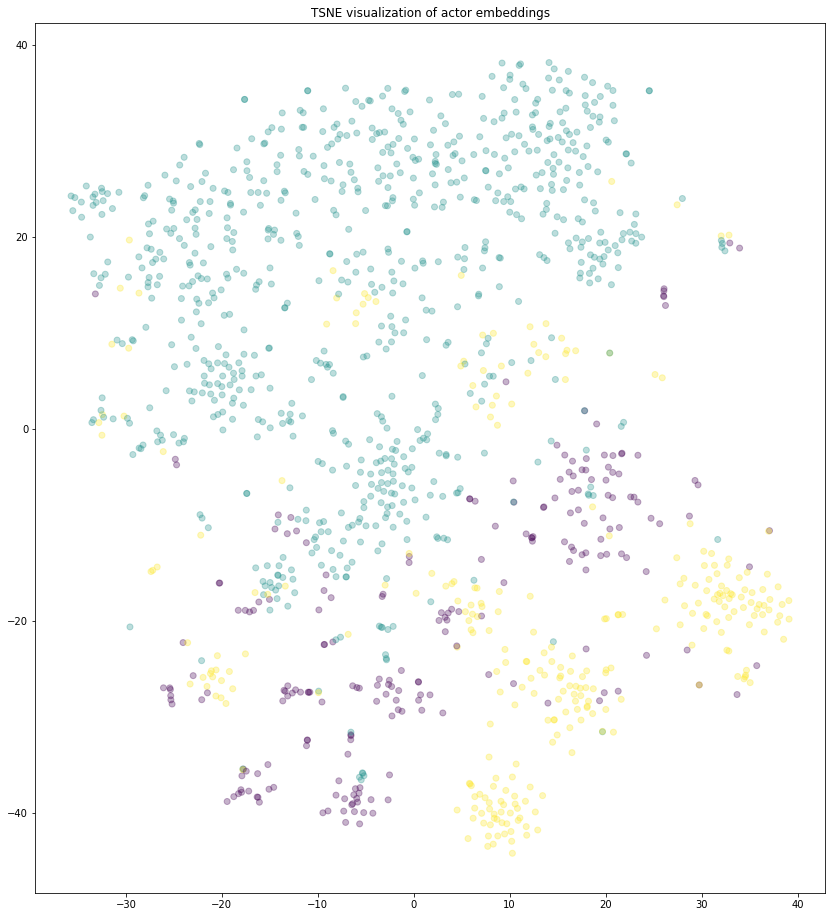

In [91]:
''' ploting of the movie clusters '''
label_map = { l: i for i, l in enumerate(np.unique(lables))}
node_colours = [label_map[target] for target in lables]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()